# Autoencoder Architecture

## Introduction
Autoencoder is a kind of Deep Learning architectures. Autoencoder architecture encompasses two sub-systems as encoder and decoder. Both these sub-systems are made up of independent Neural Network with a defined set of layers and activation functions. The fundamental characteristic feature of Autoencoder architecture is extracting the latent(hidden) data points from the given dataset. 

This notebook is created out of inspiration from the post on [Geekforgeek](https://www.geeksforgeeks.org/ml-classifying-data-using-an-auto-encoder/)

## Dataset-Credit card transactions

The dataset we're going to use in this kernel is `creditcard.csv` which basically a credit card transactions in the past. Using an encoder-decorder system we will find the hidden data points and apply a linear classifier to detect the Fraud(1) or Genuine/not-fraud (0) credit card transactions. 

## Import dependent libraries

In [1]:
import pandas as pd
import numpy as np
import os

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# SKLearn related libraries
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.decomposition import PCA


from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


# Metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, roc_curve, cohen_kappa_score, auc
from mlxtend.plotting import plot_confusion_matrix

# Keras NN related libraries
from keras import layers
from keras.layers import Input, Dense
from keras.models import Model, Sequential 
from keras import regularizers

import seaborn as sns

import random


2022-10-20 00:58:01.507308: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Loading Dataset

In [2]:
np.random.seed(1)
random.seed(1)
plt.style.use('ggplot')


data_path = '/Users/tengyujia/local-data/car-insurance/insurance_claims.csv'

data = pd.read_csv(data_path)



#data.replace('?', np.nan, inplace = True)

#data['collision_type'] = data['collision_type'].fillna(data['collision_type'].mode()[0])
#data['property_damage'] = data['property_damage'].fillna(data['property_damage'].mode()[0])
#data['police_report_available'] = data['police_report_available'].fillna(data['police_report_available'].mode()[0])

to_drop = ["_c39", "auto_model", "policy_bind_date", "policy_state", "incident_date",
               "incident_state", "incident_city", "incident_location", "policy_csl"]

data.drop(to_drop, inplace = True, axis = 1)
card_df = data

In [3]:
card_df.info()
print("===="*30)
card_df.head()
print("===="*30)
card_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   months_as_customer           1000 non-null   int64  
 1   age                          1000 non-null   int64  
 2   policy_number                1000 non-null   int64  
 3   policy_deductable            1000 non-null   int64  
 4   policy_annual_premium        1000 non-null   float64
 5   umbrella_limit               1000 non-null   int64  
 6   insured_zip                  1000 non-null   int64  
 7   insured_sex                  1000 non-null   object 
 8   insured_education_level      1000 non-null   object 
 9   insured_occupation           1000 non-null   object 
 10  insured_hobbies              1000 non-null   object 
 11  insured_relationship         1000 non-null   object 
 12  capital-gains                1000 non-null   int64  
 13  capital-loss       

,months_as_customer,age,policy_number,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_year
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000
mean,203.954000,38.948000,546238.648000,1136.000000,1256.406150,1.101000e+06,501214.488000,25126.100000,-26793.700000,11.644000,1.83900,0.992000,1.487000,52761.94000,7433.420000,7399.570000,37928.950000,2005.103000
std,115.113174,9.140287,257063.005276,611.864673,244.167395,2.297407e+06,71701.610941,27872.187708,28104.096686,6.951373,1.01888,0.820127,1.111335,26401.53319,4880.951853,4824.726179,18886.252893,6.015861
min,0.000000,19.000000,100804.000000,500.000000,433.330000,-1.000000e+06,430104.000000,0.000000,-111100.000000,0.000000,1.00000,0.000000,0.000000,100.00000,0.000000,0.000000,70.000000,1995.000000
25%,115.750000,32.000000,335980.250000,500.000000,1089.607500,0.000000e+00,448404.500000,0.000000,-51500.000000,6.000000,1.00000,0.000000,1.000000,41812.50000,4295.000000,4445.000000,30292.500000,2000.000000
50%,199.500000,38.000000,533135.000000,1000.000000,1257.200000,0.000000e+00,466445.500000,0.000000,-23250.000000,12.000000,1.00000,1.000000,1.000000,58055.00000,6775.000000,6750.000000,42100.000000,2005.000000
75%,276.250000,44.000000,759099.750000,2000.000000,1415.695000,0.000000e+00,603251.000000,51025.000000,0.000000,17.000000,3.00000,2.000000,2.000000,70592.50000,11305.000000,10885.000000,50822.500000,2010.000000
max,479.000000,64.000000,999435.000000,2000.000000,2047.590000,1.000000e+07,620962.000000,100500.000000,0.000000,23.000000,4.00000,2.000000,3.000000,114920.00000,21450.000000,23670.000000,79560.000000,2015.000000


/var/folders/hj/b1nvl8y96896vw8d6szc_3pr0000gn/T/ipykernel_88329/2802832074.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = card_df.corr()


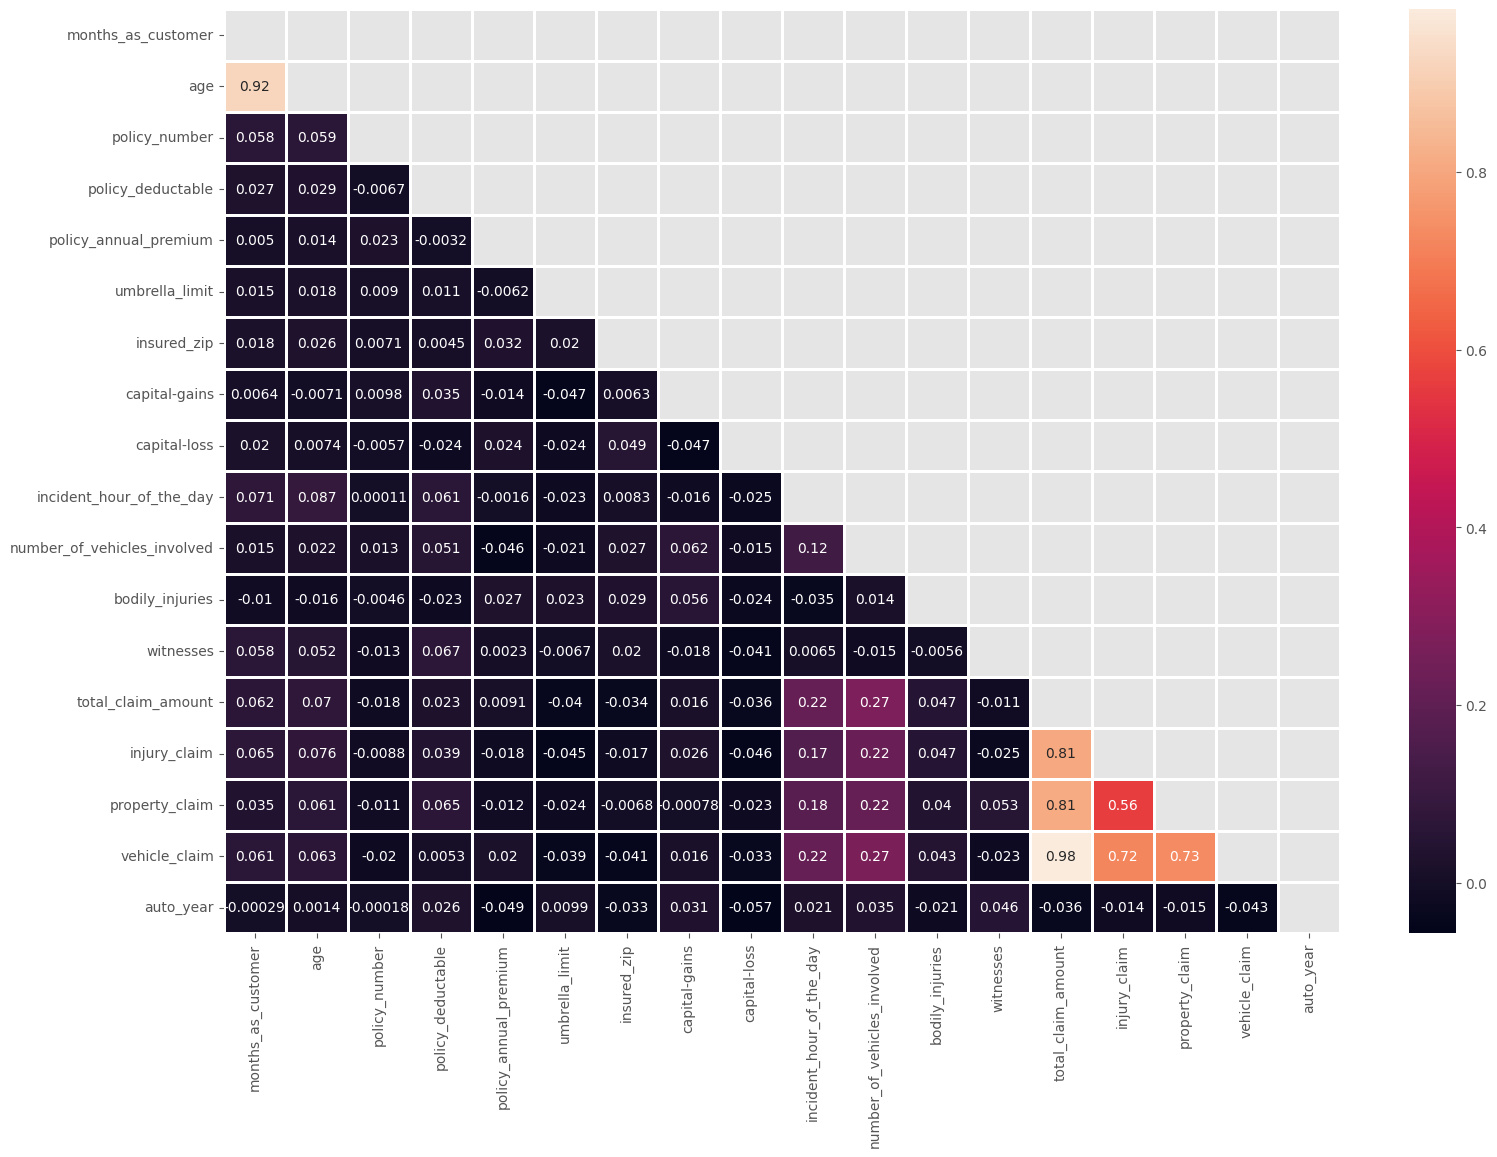

In [4]:
plt.figure(figsize = (18, 12))

corr = card_df.corr()
mask = np.triu(np.ones_like(corr, dtype = bool))

sns.heatmap(data = corr, mask = mask, annot = True, fmt = '.2g', linewidth = 1)
plt.show()

## Exploratory Data Analysis

1. Exploring on statistics information about the data

In [5]:
card_df.describe().T

,count,mean,std,min,25%,50%,75%,max
months_as_customer,1000.0,2.039540e+02,1.151132e+02,0.00,115.7500,199.5,276.250,479.00
age,1000.0,3.894800e+01,9.140287e+00,19.00,32.0000,38.0,44.000,64.00
policy_number,1000.0,5.462386e+05,2.570630e+05,100804.00,335980.2500,533135.0,759099.750,999435.00
policy_deductable,1000.0,1.136000e+03,6.118647e+02,500.00,500.0000,1000.0,2000.000,2000.00
policy_annual_premium,1000.0,1.256406e+03,2.441674e+02,433.33,1089.6075,1257.2,1415.695,2047.59
umbrella_limit,1000.0,1.101000e+06,2.297407e+06,-1000000.00,0.0000,0.0,0.000,10000000.00
insured_zip,1000.0,5.012145e+05,7.170161e+04,430104.00,448404.5000,466445.5,603251.000,620962.00
capital-gains,1000.0,2.512610e+04,2.787219e+04,0.00,0.0000,0.0,51025.000,100500.00
capital-loss,1000.0,-2.679370e+04,2.810410e+04,-111100.00,-51500.0000,-23250.0,0.000,0.00
incident_hour_of_the_day,1000.0,1.164400e+01,6.951373e+00,0.00,6.0000,12.0,17.000,23.00


In [6]:
# Unique class labels
print(f"Unique classes in the dataset are : {np.unique(card_df['fraud_reported'])}" )

Unique classes in the dataset are : ['N' 'Y']


<AxesSubplot: xlabel='fraud_reported'>

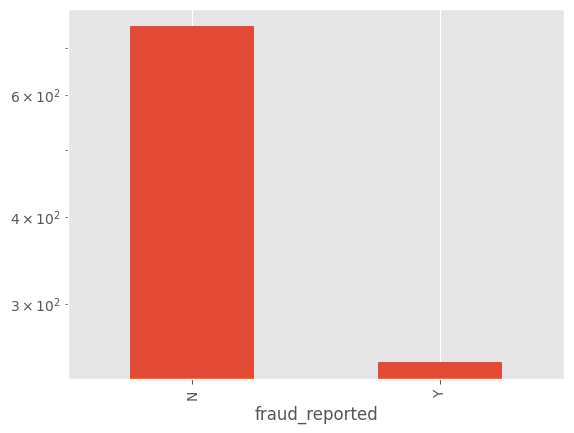

In [7]:
card_df.groupby('fraud_reported')['fraud_reported'].count().plot.bar(logy=True)

## Trasnformation

Data transformation is one of the steps in data processing. We need to transform certain attributes value so that it makes sense in the further analysis. 

In [8]:
predictors = card_df.iloc[:,:-1]
response = card_df.iloc[:, -1]

# response_columns = response

修改标签列数据类型

In [9]:
response = response.replace({'Y':1,'N':0})
response.head()

0    1
1    1
2    0
3    1
4    0
Name: fraud_reported, dtype: int64

one-hot 编码

In [10]:
categorical_data = predictors.select_dtypes(exclude="number")
one_hot_columns = categorical_data.columns

predictors = predictors.drop(one_hot_columns, axis=1)

one_hot_data = pd.get_dummies(categorical_data)
# predictors_one_hot = predictors.join(one_hot_data)

In [11]:
one_hot_data.info(verbose=True)
one_hot_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 86 columns):
 #   Column                                  Non-Null Count  Dtype
---  ------                                  --------------  -----
 0   insured_sex_FEMALE                      1000 non-null   uint8
 1   insured_sex_MALE                        1000 non-null   uint8
 2   insured_education_level_Associate       1000 non-null   uint8
 3   insured_education_level_College         1000 non-null   uint8
 4   insured_education_level_High School     1000 non-null   uint8
 5   insured_education_level_JD              1000 non-null   uint8
 6   insured_education_level_MD              1000 non-null   uint8
 7   insured_education_level_Masters         1000 non-null   uint8
 8   insured_education_level_PhD             1000 non-null   uint8
 9   insured_occupation_adm-clerical         1000 non-null   uint8
 10  insured_occupation_armed-forces         1000 non-null   uint8
 11  insured_occupation

,insured_sex_FEMALE,insured_sex_MALE,insured_education_level_Associate,insured_education_level_College,insured_education_level_High School,insured_education_level_JD,insured_education_level_MD,insured_education_level_Masters,insured_education_level_PhD,insured_occupation_adm-clerical,...,auto_make_Dodge,auto_make_Ford,auto_make_Honda,auto_make_Jeep,auto_make_Mercedes,auto_make_Nissan,auto_make_Saab,auto_make_Suburu,auto_make_Toyota,auto_make_Volkswagen
0,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
# predictors = predictors.astype('float')

# final_predictors = predictors_one_hot.join(response)

In [13]:
# Sampling of data
# normal_trans = final_predictors[final_predictors['fraud_reported'] == 0]
# fraud_trans = final_predictors[final_predictors['fraud_reported'] == 1]

In [14]:
# reduced_set = normal_trans.append(fraud_trans).reset_index(drop=True)

In [15]:
# print(f"Cleansed dataset shape : {reduced_set.shape}")

## Split the Dataset

In [16]:
# Splitting the dataset into X and y features
# y = final_predictors['fraud_reported']
# X = final_predictors.drop('fraud_reported', axis=1)


In [17]:
# print(f"Shape of Features : {X.shape} and Target: {y.shape}")



## Visualize the data with t-SNE

TNSE(t-distributed Stochastic Neighbor Embedding) is one of the dimensionality reduction method other than PCA and SVD. This will supress some noise and speed up the computation of pairwise distance between samples. 

In [18]:
def dimensionality_plot(X, y):
    sns.set(style='whitegrid', palette='muted')
    # Initializing TSNE object with 2 principal components
    tsne = TSNE(n_components=2, random_state = 42)
    
    # Fitting the data
    X_trans = tsne.fit_transform(X)
    
    plt.figure(figsize=(12,8))
    
    plt.scatter(X_trans[np.where(y == 0), 0], X_trans[np.where(y==0), 1], marker='o', color='g', linewidth=1, alpha=0.8, label='Normal')
    plt.scatter(X_trans[np.where(y == 1), 0], X_trans[np.where(y==1), 1], marker='o', color='k', linewidth=1, alpha=0.8, label='Fraud')
    
    plt.legend(loc = 0)
    
    plt.show()



/Users/tengyujia/ml_project/car-insurance/venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/tengyujia/ml_project/car-insurance/venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


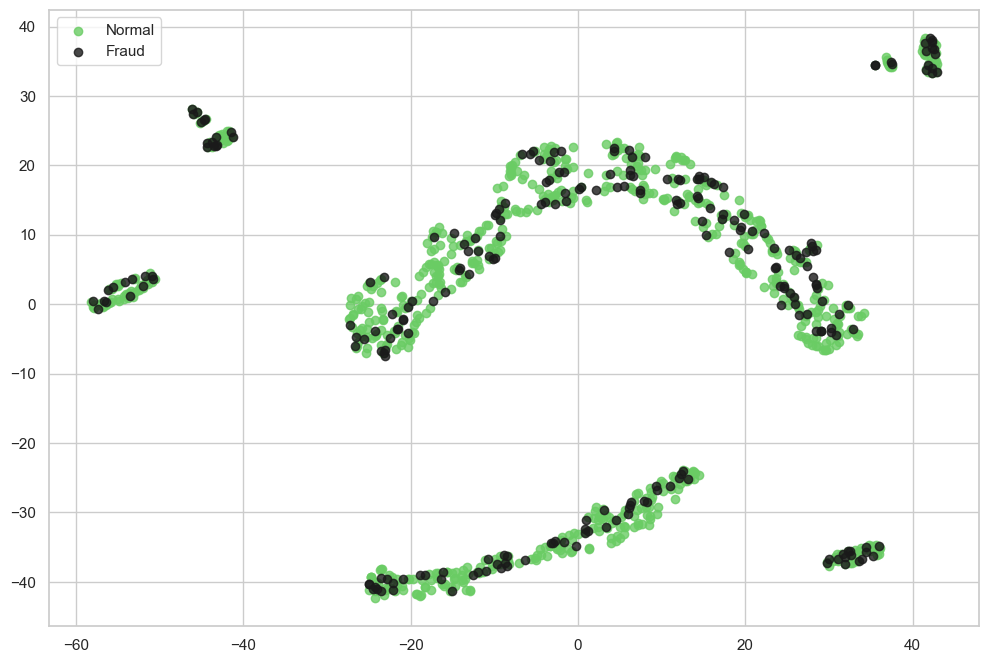

In [19]:
# Invoking the method dimensionality_plot
dimensionality_plot(predictors, response)

## Normalize and Scale the features

In [20]:

scaler = StandardScaler().fit_transform(predictors)

scaler_df = pd.DataFrame(data = scaler, columns = predictors.columns)
scaler_df = scaler_df.join(one_hot_data)
scaler_df.head()


,months_as_customer,age,policy_number,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,capital-gains,capital-loss,incident_hour_of_the_day,...,auto_make_Dodge,auto_make_Ford,auto_make_Honda,auto_make_Jeep,auto_make_Mercedes,auto_make_Nissan,auto_make_Saab,auto_make_Suburu,auto_make_Toyota,auto_make_Volkswagen
0,1.078140,0.990836,-0.095953,-0.222383,0.616705,-0.479476,-0.489529,1.011331,0.953851,-0.956261,...,0,0,0,0,0,0,1,0,0,0
1,0.208995,0.334073,-0.791527,1.412784,-0.242521,1.697980,-0.461008,-0.901927,0.953851,-0.524475,...,0,0,0,0,1,0,0,0,0,0
2,-0.608002,-1.088913,0.550566,1.412784,0.642233,1.697980,-0.984885,0.358023,0.953851,-0.668404,...,1,0,0,0,0,0,0,0,0,0
3,0.452355,0.224613,-1.239334,1.412784,0.652886,2.133471,1.491682,0.853388,-1.267577,-0.956261,...,0,0,0,0,0,0,0,0,0,0
4,0.208995,0.552994,-0.695834,-0.222383,1.341980,2.133471,1.527808,1.467210,-0.683741,1.202666,...,0,0,0,0,0,0,0,0,0,0


/Users/tengyujia/ml_project/car-insurance/venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/tengyujia/ml_project/car-insurance/venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


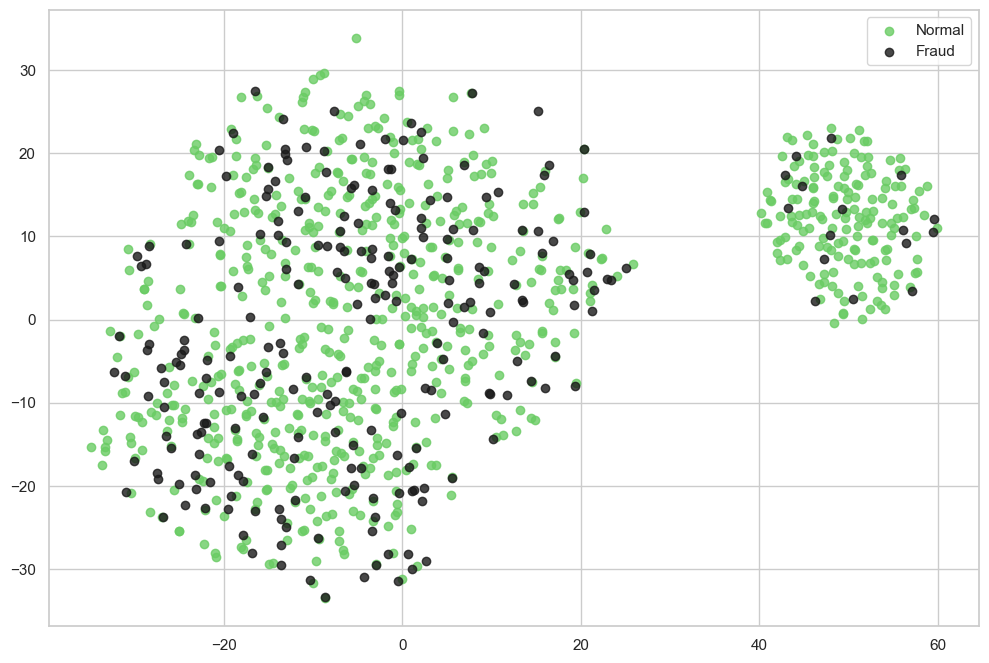

In [21]:
y = response
X = scaler_df
# X = predictors.join(one_hot_data)
dimensionality_plot(X, y)

In [22]:
feature_size = 40

pca = PCA(n_components=feature_size)
pca_X = pca.fit_transform(X)
print(pca.explained_variance_ratio_)

[0.14290914 0.07156252 0.0496232  0.0425811  0.04025231 0.03962738
 0.03847304 0.03734542 0.03566579 0.0355014  0.03476582 0.03421729
 0.03322337 0.03140651 0.01822292 0.01626569 0.01391162 0.01259307
 0.01242356 0.01154805 0.01120453 0.010604   0.01037336 0.0099247
 0.00934981 0.00876381 0.00793275 0.00728839 0.00669956 0.00661328
 0.00635816 0.00592796 0.00580158 0.00545253 0.0051884  0.00509201
 0.00501757 0.00477804 0.00431424 0.00415917]


/Users/tengyujia/ml_project/car-insurance/venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/tengyujia/ml_project/car-insurance/venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


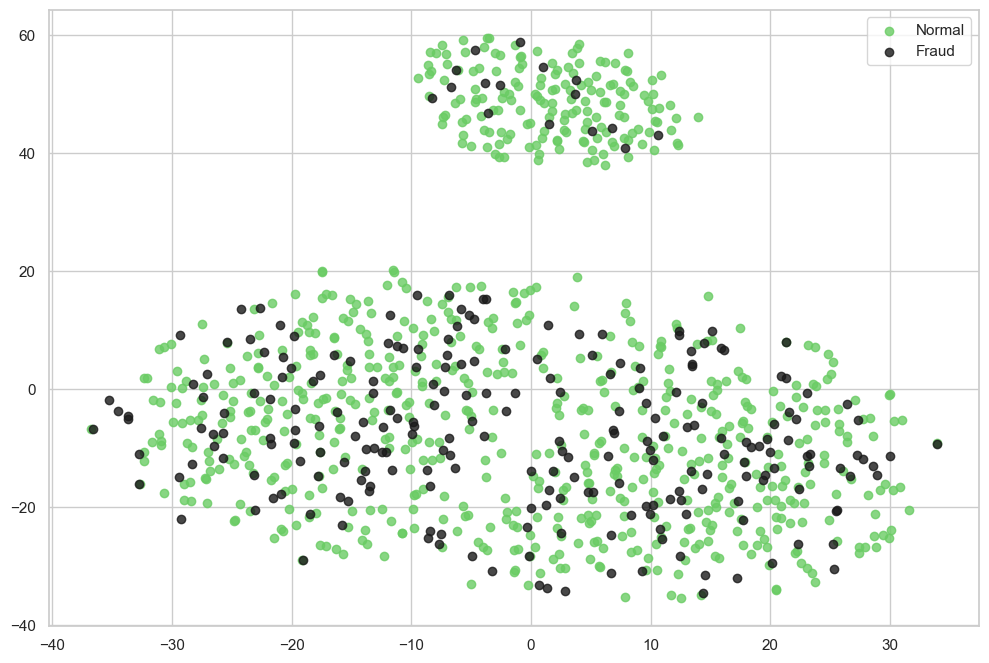

In [23]:
# Invoking the method dimensionality_plot
dimensionality_plot(pca_X, y)

In [24]:
# Scaled data
X_scaled_normal = pca_X[y == 0]
X_scaled_fraud = pca_X[y == 1]

## Building Autoencoder Model

In [25]:
print(f"Shape of the input data : {feature_size}")

Shape of the input data : 40


In [26]:
# Input layer with a shape of features/columns of the dataset
input_layer = Input(shape = (feature_size, ))

# Construct encoder network
encoded = Dense(100, activation= 'tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(encoded)
encoded = Dense(25, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(encoded)
encoded = Dense(12, activation = 'tanh', activity_regularizer=regularizers.l1(10e-5))(encoded)
encoded = Dense(6, activation='relu')(encoded)

# Decoder network
decoded = Dense(12, activation='tanh')(encoded)
decoded = Dense(25, activation='tanh')(decoded)
decoded = Dense(50, activation='tanh')(decoded)
decoded = Dense(100, activation='tanh')(decoded)

output_layer = Dense(feature_size, activation='relu')(decoded)

# Building a model
auto_encoder = Model(input_layer, output_layer)

2022-10-20 00:58:13.540799: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [27]:
# Compile the auto encoder model
auto_encoder.compile(optimizer='adadelta', loss='mse')

# Training the auto encoder model
auto_encoder.fit(X_scaled_normal, X_scaled_normal, batch_size=32, epochs=20, shuffle=True, validation_split=0.20)

Epoch 1/20
19/19 [==============================] - 1s 11ms/step - loss: 0.6297 - val_loss: 0.6190
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 0.6295 - val_loss: 0.6189
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 0.6294 - val_loss: 0.6188
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 0.6293 - val_loss: 0.6187
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 0.6292 - val_loss: 0.6186
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 0.6291 - val_loss: 0.6185
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 0.6290 - val_loss: 0.6184
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 0.6288 - val_loss: 0.6183
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 0.6287 - val_loss: 0.6182
Epoch 10/20
19/19 [==============================] - 0s 3ms/step - loss: 0.6286 - val_loss: 0.6181
Epoch 11/20
19/19 

## Using Autoencode to encode data

In [28]:
latent_model = Sequential()
latent_model.add(auto_encoder.layers[0])
latent_model.add(auto_encoder.layers[1])
latent_model.add(auto_encoder.layers[2])
latent_model.add(auto_encoder.layers[3])
latent_model.add(auto_encoder.layers[4])

In [29]:
normal_tran_points = latent_model.predict(X_scaled_normal)
fraud_tran_points = latent_model.predict(X_scaled_fraud)
# Making as a one collection
encoded_X = np.append(normal_tran_points, fraud_tran_points, axis=0)
y_normal = np.zeros(normal_tran_points.shape[0])
y_fraud = np.ones(fraud_tran_points.shape[0])
encoded_y = np.append(y_normal, y_fraud, axis=0)


8/8 [==============================] - 0s 1ms/step


/Users/tengyujia/ml_project/car-insurance/venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/tengyujia/ml_project/car-insurance/venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


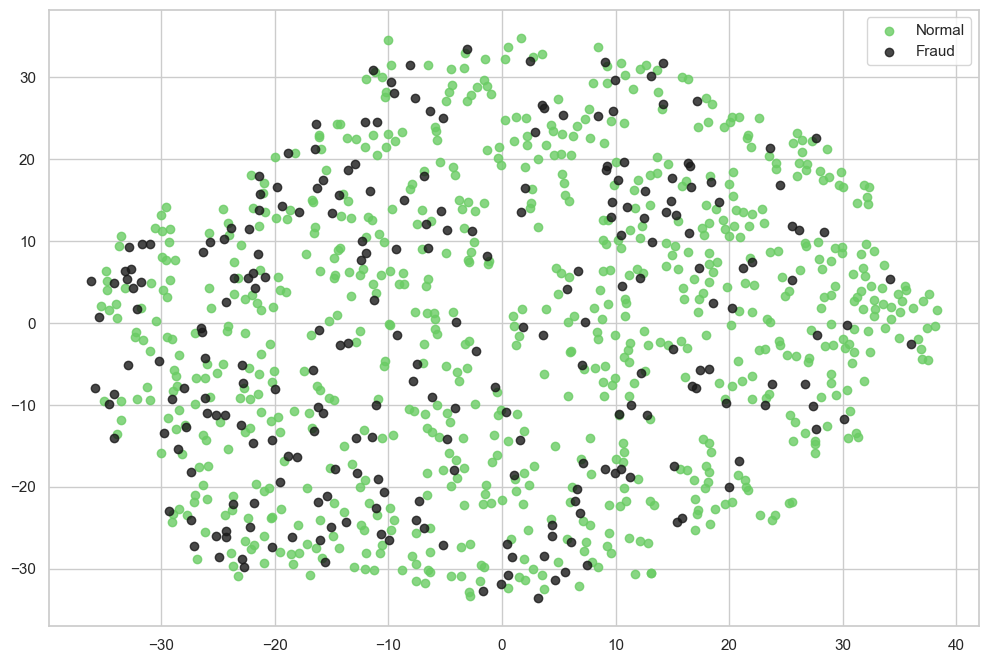

In [30]:
# Calling TSNE plot function
dimensionality_plot(encoded_X, encoded_y)

We can observe that the encoded fraud data points have been moved towards one cluster, whereas there are only few fraud transaction datapoints are there among the normal transaction data points. 

## Split into Train and Test

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_enc_train, X_enc_test, y_enc_train, y_enc_test = train_test_split(encoded_X, encoded_y, test_size=0.3)

In [32]:
print(f"Encoded train data X: {X_enc_train.shape}, Y: {y_enc_train.shape}, X_test :{X_enc_test.shape}, Y_test: {y_enc_test.shape}")
print(f"Actual train & test data X: {X_train.shape}, Y: {X_train.shape}, X_test :{X_test.shape}, Y_test: {y_test.shape}")

Encoded train data X: (700, 12), Y: (700,), X_test :(300, 12), Y_test: (300,)
Actual train & test data X: (700, 104), Y: (700, 104), X_test :(300, 104), Y_test: (300,)


# 评价函数

In [33]:
def cal_sorce(response_test,predictions_test):
    conf_matrix = confusion_matrix(predictions_test, response_test)
    plot_confusion_matrix(conf_matrix)

    precision = precision_score(predictions_test, response_test)
    recall = recall_score(predictions_test, response_test)

    print("*****************************************")
    print("Results on testing data:")
    print("*****************************************")
    print("Accuracy = "+str(accuracy_score(predictions_test, response_test)))
    print("Precision = "+str(precision))
    print("Recall = "+str(recall))

    tpr, fpr, threshold = roc_curve(predictions_test, response_test, pos_label=1)
    print()
    print("AUC value = "+str(auc(tpr, fpr)))
    print("f1 value = "+str(f1_score(response_test, predictions_test, average='binary', pos_label=1)))
    print("Cohen Kappa Score = "+str(cohen_kappa_score(predictions_test, response_test)))

## Non-linear Classifier

*****************************************
Results on testing data:
*****************************************
Accuracy = 0.7366666666666667
Precision = 0.12345679012345678
Recall = 0.5555555555555556

AUC value = 0.6518912529550828
f1 value = 0.20202020202020202
Cohen Kappa Score = 0.11514336917562729


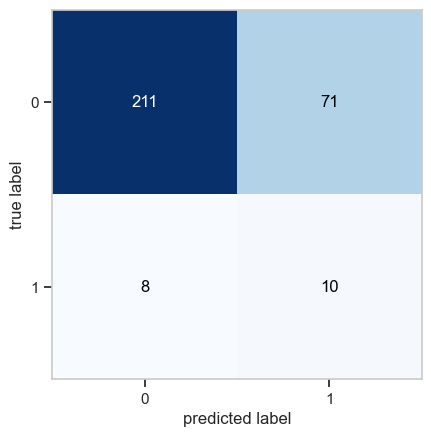

In [34]:
# Instance of SVM
svc_clf = SVC()

svc_clf.fit(X_train, y_train)

svc_predictions = svc_clf.predict(X_test)
cal_sorce(y_test, svc_predictions)

In [35]:
# print("Classification report \n {0}".format(classification_report(y_test, svc_predictions)))

In [36]:
# print("Accuracy of SVC \n {:.2f}".format(accuracy_score(y_test, svc_predictions)))

## Linear Classifier

Now let's apply linear classifier to classify the data and observe the result. We will use **Logistic Regression** to build the model.

In [37]:
# lr_clf = LogisticRegression()

# lr_clf.fit(X_enc_train, y_enc_train)

# # Predict the Test data
# predictions = lr_clf.predict(X_enc_test)

# cal_sorce(y_enc_test, predictions)

In [38]:
# print("Classification report \n {0}".format(classification_report(y_enc_test, predictions)))


In [39]:
# print("Accuracy score is : {:.2f}".format(accuracy_score(y_enc_test, predictions)))

## Conclusion

In this analysis, we have found that Support Vector Machine classifier is able to classify the data upto **93%** without encoding and decoding. However, the effect of autoencoder comes when the data gets transformed from non-linear to linearly separable then linear classifier like **Logistic Regression** could perform in a better way.

The accuracy score of Logistic Regression can go upto **97%**, this is something not happens too often in logistic algorithm. 

# 随机森林

*****************************************
Results on testing data:
*****************************************
Accuracy = 0.7366666666666667
Precision = 0.05063291139240506
Recall = 0.5

AUC value = 0.6215753424657533
f1 value = 0.09195402298850573
Cohen Kappa Score = 0.04574005475922038


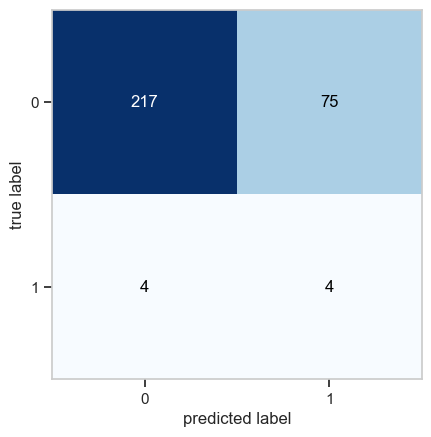

In [40]:
random_forest = RandomForestClassifier()

random_forest.fit(X_enc_train, y_enc_train)

# Predict the Test data
rf_predictions = random_forest.predict(X_enc_test)

#print("Classification report \n {0}".format(classification_report(y_enc_test, predictions)))
#print("Accuracy score is : {:.2f}".format(accuracy_score(y_enc_test, predictions)))
cal_sorce(y_enc_test,rf_predictions)

In [41]:
sm = SMOTE(random_state=24)
sm_predictors, sm_response = sm.fit_resample(X_enc_train, y_enc_train)


*****************************************
Results on testing data:
*****************************************
Accuracy = 0.6966666666666667
Precision = 0.25316455696202533
Recall = 0.38461538461538464

AUC value = 0.5733560794044664
f1 value = 0.30534351145038174
Cohen Kappa Score = 0.1217346544846224


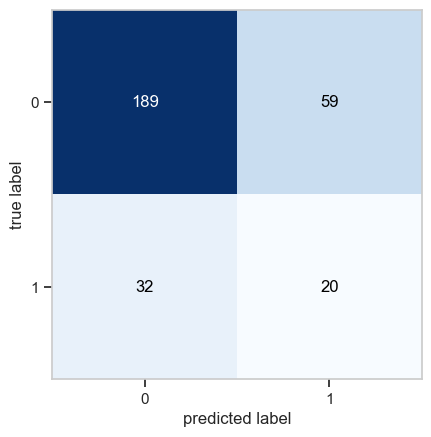

In [42]:

random_forest_sm = RandomForestClassifier()

random_forest_sm.fit(sm_predictors, sm_response)

# Predict the Test data
rf_smote_predictions = random_forest_sm.predict(X_enc_test)

# print("Classification report \n {0}".format(classification_report(y_enc_test, predictions)))
# print("Accuracy score is : {:.2f}".format(accuracy_score(y_enc_test, predictions)))
cal_sorce(y_enc_test, rf_smote_predictions)

*****************************************
Results on testing data:
*****************************************
Accuracy = 0.8033333333333333
Precision = 0.5308641975308642
Recall = 0.671875

AUC value = 0.7554290254237288
f1 value = 0.593103448275862
Cohen Kappa Score = 0.4657732705541471


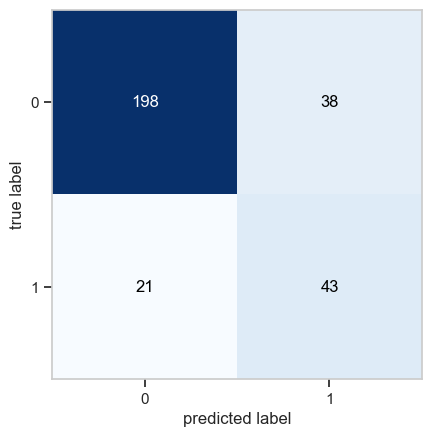

In [43]:

random_forest_no_encoder = RandomForestClassifier()

sm = SMOTE(random_state=24)
sm_predictors, sm_response = sm.fit_resample(X_train, y_train)

random_forest_no_encoder.fit(sm_predictors, sm_response)

# Predict the Test data
rf_somote_no_encoder_predictions = random_forest_no_encoder.predict(X_test)
#print("Classification report \n {0}".format(classification_report(y_test, predictions,zero_division = 0)))
#print("Accuracy of SVC \n {:.2f}".format(accuracy_score(y_test, predictions)))

cal_sorce(y_test, rf_somote_no_encoder_predictions)


# Decision Tree

In [44]:
dtc = DecisionTreeClassifier()

grid_params = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [3, 5, 7, 10],
    'min_samples_split' : range(2, 10, 1),
    'min_samples_leaf' : range(2, 10, 1)
}

grid_search = GridSearchCV(dtc, grid_params, cv = 5, n_jobs = -1, verbose = 1)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)

Fitting 5 folds for each of 512 candidates, totalling 2560 fits
{'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2}
0.8457142857142858


*****************************************
Results on testing data:
*****************************************
Accuracy = 0.81
Precision = 0.5555555555555556
Recall = 0.6818181818181818

AUC value = 0.763986013986014
f1 value = 0.6122448979591836
Cohen Kappa Score = 0.4881465517241379


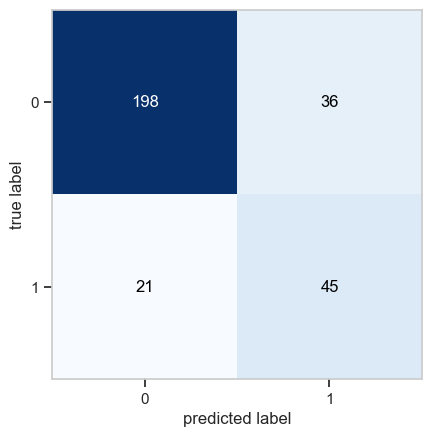

In [45]:

dtc = grid_search.best_estimator_

y_pred = dtc.predict(X_test)

cal_sorce(y_test, y_pred)